## Library Import

In [6]:
import time
import os
import re
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import emoji
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import lime
from lime.lime_text import LimeTextExplainer
from collections import defaultdict
from joblib import Parallel, delayed

In [7]:
# Load the dataset
file_path = "Sentiment_Data.csv"

# Attempt different encodings if UTF-8 fails
encodings = ["utf-8", "ISO-8859-1", "latin1"]

for enc in encodings:
    try:
        df = pd.read_csv(file_path, encoding=enc)
        print(f"Successfully loaded with encoding: {enc}")
        break  # Stop if successful
    except UnicodeDecodeError:
        print(f"Encoding {enc} failed, trying next...")

Encoding utf-8 failed, trying next...
Successfully loaded with encoding: ISO-8859-1


In [8]:
df.head()

Tweet Sentiment
0  @_angelica_toy Happy Anniversary!!!....The Day...  Mild_Pos
1  @McfarlaneGlenda Happy Anniversary!!!....The D...  Mild_Pos
2  @thevivafrei @JustinTrudeau Happy Anniversary!...  Mild_Pos
3  @NChartierET Happy Anniversary!!!....The Day t...  Mild_Pos
4  @tabithapeters05 Happy Anniversary!!!....The D...  Mild_Pos

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451332 entries, 0 to 451331
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet      451331 non-null  object
 1   Sentiment  451332 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB


In [10]:
df.isnull().sum()

Tweet        1
Sentiment    0
dtype: int64

In [11]:
df.dropna(inplace =True)

In [12]:
df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [13]:
df['Sentiment'].unique()

array(['Mild_Pos', 'Strong_Pos', 'Neutral', 'Strong_Neg', 'Mild_Neg'],
      dtype=object)

New Class Distribution:
Sentiment
Positive    297704
Neutral      77015
Negative     76612
Name: count, dtype: int64


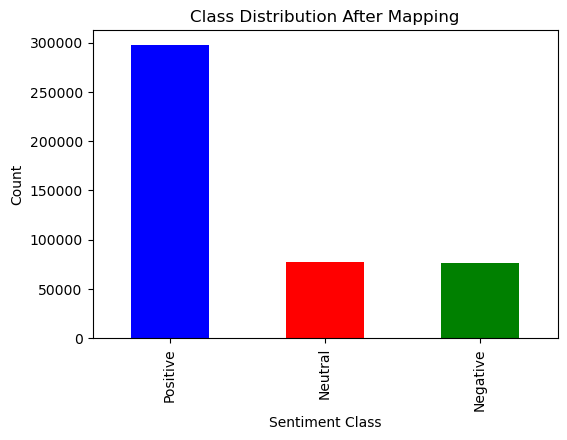

In [14]:
import matplotlib.pyplot as plt

# Map sentiments to three classes
sentiment_mapping = {
    "Mild_Pos": "Positive",
    "Strong_Pos": "Positive",
    "Mild_Neg": "Negative",
    "Strong_Neg": "Negative",
    "Neutral": "Neutral"
}

df["Sentiment"] = df["Sentiment"].map(sentiment_mapping)

# Check class distribution
print("New Class Distribution:")
print(df["Sentiment"].value_counts())

# Plot class distribution
plt.figure(figsize=(6,4))
df["Sentiment"].value_counts().plot(kind="bar", color=["blue", "red", "green"])
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.title("Class Distribution After Mapping")
plt.show()

In [15]:
# Function to remove URLs
def remove_urls(text):
    return re.sub(r"http\S+|www\S+", "", text)

# Function to remove mentions and hashtags
def remove_mentions_hashtags(text):
    return re.sub(r"@\w+|#\w+", "", text)

# Apply regex transformations
df["Tweet_Cleaned"] = df["Tweet"].astype(str)
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(remove_urls)
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(remove_mentions_hashtags)

# Count regex transformations
regex_count = df["Tweet"].str.contains(r"http\S+|www\S+|@\w+|#\w+", regex=True).sum()

print(f"Regex Applied: {regex_count} changes")

Regex Applied: 405578 changes


In [17]:
# Function to replace emojis with text equivalents
def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))  # Convert emoji to text

# Apply emoji transformation
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(replace_emojis)

# Count emoji replacements
emoji_count = df["Tweet"].str.contains(r"[^\w\s,]", regex=True).sum()

print(f"Emojis Replaced: {emoji_count} emojis")

Emojis Replaced: 449126 emojis


In [18]:
# Slang dictionary
slang_dict = {
    "brb": "be right back",
    "lol": "laugh out loud",
    "idk": "I don’t know",
    "imo": "in my opinion",
    "btw": "by the way"
}

# Function to expand slangs
def expand_slang(text):
    words = text.split()
    return " ".join([slang_dict[word.lower()] if word.lower() in slang_dict else word for word in words])

# Apply slang transformation
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(expand_slang)

# Count slang replacements
slang_count = sum([df["Tweet"].str.contains(word, case=False, na=False).sum() for word in slang_dict.keys()])

print(f"Slangs Expanded: {slang_count} slangs")

Slangs Expanded: 7142 slangs


In [19]:
# Display a few cleaned tweets
print("\nSample Cleaned Tweets:")
df[["Tweet", "Tweet_Cleaned"]].head()


Sample Cleaned Tweets:


Tweet  \
0  @_angelica_toy Happy Anniversary!!!....The Day...   
1  @McfarlaneGlenda Happy Anniversary!!!....The D...   
2  @thevivafrei @JustinTrudeau Happy Anniversary!...   
3  @NChartierET Happy Anniversary!!!....The Day t...   
4  @tabithapeters05 Happy Anniversary!!!....The D...   

                                       Tweet_Cleaned  
0  Happy Anniversary!!!....The Day the FreeDUMB D...  
1  Happy Anniversary!!!....The Day the FreeDUMB D...  
2  Happy Anniversary!!!....The Day the FreeDUMB D...  
3  Happy Anniversary!!!....The Day the FreeDUMB D...  
4  Happy Anniversary!!!....The Day the FreeDUMB D...

In [25]:
# Convert text into TF-IDF features
vectorizer = TfidfVectorizer(max_features=500)  # Use top 500 words
X_tfidf = vectorizer.fit_transform(df["Tweet_Cleaned"])

# Convert to DataFrame for analysis
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df["Sentiment"] = df["Sentiment"]

print("TF-IDF feature shape:", X_tfidf.shape)
tfidf_df.head()

TF-IDF feature shape: (451331, 500)


000   10  100   19  2022  about  account  accounts  across  act  ...  yes  \
0  0.0  0.0  0.0  0.0   0.0    0.0      0.0       0.0     0.0  0.0  ...  0.0   
1  0.0  0.0  0.0  0.0   0.0    0.0      0.0       0.0     0.0  0.0  ...  0.0   
2  0.0  0.0  0.0  0.0   0.0    0.0      0.0       0.0     0.0  0.0  ...  0.0   
3  0.0  0.0  0.0  0.0   0.0    0.0      0.0       0.0     0.0  0.0  ...  0.0   
4  0.0  0.0  0.0  0.0   0.0    0.0      0.0       0.0     0.0  0.0  ...  0.0   

   yet  you  your  youâ   ªã   ³ã   ºð   ï¼  Sentiment  
0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   Positive  
1  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   Positive  
2  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   Positive  
3  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   Positive  
4  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   Positive  

[5 rows x 501 columns]

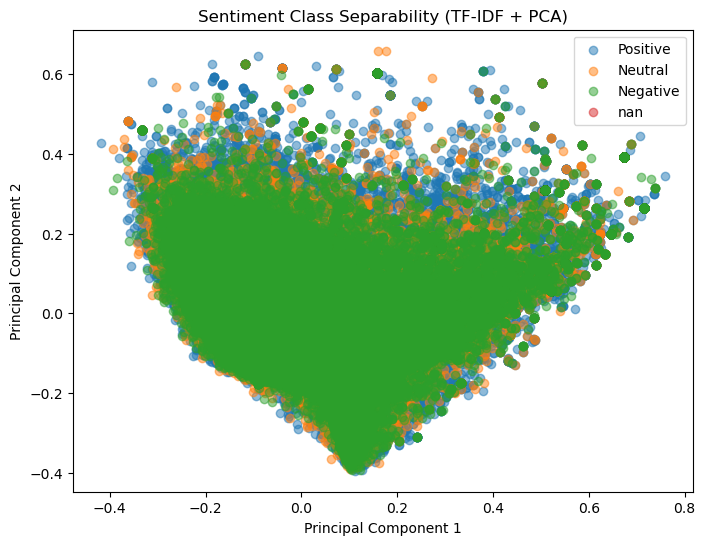

In [29]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Convert to DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Sentiment"] = df["Sentiment"]

# Plot PCA visualization
plt.figure(figsize=(8,6))
for sentiment in pca_df["Sentiment"].unique():
    subset = pca_df[pca_df["Sentiment"] == sentiment]
    plt.scatter(subset["PC1"], subset["PC2"], label=sentiment, alpha=0.5)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Sentiment Class Separability (TF-IDF + PCA)")
plt.legend()
plt.show()

In [30]:
# Tokenize each tweet into words
df["Tokenized_Tweet"] = df["Tweet_Cleaned"].apply(lambda x: word_tokenize(x.lower()))

# Display sample tokenized tweets
df[["Tweet_Cleaned", "Tokenized_Tweet"]].head()

Tweet_Cleaned  \
0  Happy Anniversary!!!....The Day the FreeDUMB D...   
1  Happy Anniversary!!!....The Day the FreeDUMB D...   
2  Happy Anniversary!!!....The Day the FreeDUMB D...   
3  Happy Anniversary!!!....The Day the FreeDUMB D...   
4  Happy Anniversary!!!....The Day the FreeDUMB D...   

                                     Tokenized_Tweet  
0  [happy, anniversary, !, !, !, ...., the, day, ...  
1  [happy, anniversary, !, !, !, ...., the, day, ...  
2  [happy, anniversary, !, !, !, ...., the, day, ...  
3  [happy, anniversary, !, !, !, ...., the, day, ...  
4  [happy, anniversary, !, !, !, ...., the, day, ...

In [31]:
# Configurable parameters
embedding_size = 100  # Choose between 64-300
window_size = 5       # Context window size
min_word_count = 2    # Ignore words with <2 occurrences
model_type = 1        # 0 = CBOW, 1 = Skip-gram

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=df["Tokenized_Tweet"],
    vector_size=embedding_size,
    window=window_size,
    min_count=min_word_count,
    sg=model_type,  # 0 = CBOW, 1 = Skip-gram
    workers=4
)

# Save the model for reuse
w2v_model.save("word2vec_model.bin")
print("Word2Vec model trained and saved!")

Word2Vec model trained and saved!


In [32]:
# Function to get average word embedding for a tweet
def tweet_to_vec(tweet, model, embedding_size):
    vectors = [model.wv[word] for word in tweet if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_size)

# Convert all tweets to their respective embedding vectors
df["Tweet_Vector"] = df["Tokenized_Tweet"].apply(lambda x: tweet_to_vec(x, w2v_model, embedding_size))

# Display sample vectors
print("\nSample Tweet Embeddings:")
df["Tweet_Vector"].head()


Sample Tweet Embeddings:


0    [0.15947454, -0.077519886, -0.22720194, 0.2549...
1    [0.15947454, -0.077519886, -0.22720194, 0.2549...
2    [0.15947454, -0.077519886, -0.22720194, 0.2549...
3    [0.15947454, -0.077519886, -0.22720194, 0.2549...
4    [0.15947454, -0.077519886, -0.22720194, 0.2549...
Name: Tweet_Vector, dtype: object

In [33]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_labels = ["Positive", "Neutral", "Negative"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(class_labels),
    y=df["Sentiment"]
)

# Convert to dictionary format for PyTorch
class_weights_dict = {label: weight for label, weight in zip(class_labels, class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {'Positive': 0.5053464739024893, 'Neutral': 1.953433313856608, 'Negative': 1.9637089054804295}


In [35]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Sentiment"])  # 0 = Negative, 1 = Neutral, 2 = Positive

# Convert to NumPy arrays
X = np.array(df["Tweet_Vector"].tolist())
y = np.array(df["Label"])

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch Dataset
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 64
train_dataset = SentimentDataset(X_train_tensor, y_train_tensor)
test_dataset = SentimentDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model

In [37]:
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.3):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Bi-directional output
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension
        gru_out, _ = self.gru(x)
        out = self.dropout(gru_out[:, -1, :])  # Last output from Bi-GRU
        out = self.fc(out)
        return out

# Model Parameters
input_size = X_train.shape[1]  # Embedding size (Word2Vec)
hidden_size = 128
output_size = len(np.unique(y))  # 3 classes (Positive, Neutral, Negative)
num_layers = 1

# Initialize Model
model = BiGRU(input_size, hidden_size, output_size, num_layers)
print(model)

BiGRU(
  (gru): GRU(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [38]:
# Convert class weights to tensor for PyTorch
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float32)

# Define loss function with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model & tensors to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [39]:
num_epochs = 50  # Max epochs
patience = 5  # Early stopping patience
best_val_loss = float("inf")
early_stop_count = 0

results = []

print("Training Started...")
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    y_train_pred, y_train_true = [], []

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(batch_y.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    y_val_pred, y_val_true = [], []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_val_pred.extend(predicted.cpu().numpy())
            y_val_true.extend(batch_y.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    avg_val_loss = total_val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_count = 0
        torch.save(model, "best_biGRU_model.pth")  # Save best model
    else:
        early_stop_count += 1

    if early_stop_count >= patience:
        print("Early stopping triggered!")
        break

training_time = time.time() - start_time
print(f"Training Completed in {training_time:.2f} seconds")

Training Started...
Epoch [1/50] - Train Loss: 0.5312 | Train Acc: 0.7078 | Val Loss: 0.5062 | Val Acc: 0.7124
Epoch [2/50] - Train Loss: 0.5011 | Train Acc: 0.7203 | Val Loss: 0.4919 | Val Acc: 0.7355
Epoch [3/50] - Train Loss: 0.4866 | Train Acc: 0.7277 | Val Loss: 0.4752 | Val Acc: 0.7291
Epoch [4/50] - Train Loss: 0.4760 | Train Acc: 0.7332 | Val Loss: 0.4712 | Val Acc: 0.7292
Epoch [5/50] - Train Loss: 0.4683 | Train Acc: 0.7368 | Val Loss: 0.4626 | Val Acc: 0.7354
Epoch [6/50] - Train Loss: 0.4627 | Train Acc: 0.7402 | Val Loss: 0.4628 | Val Acc: 0.7493
Epoch [7/50] - Train Loss: 0.4570 | Train Acc: 0.7434 | Val Loss: 0.4525 | Val Acc: 0.7434
Epoch [8/50] - Train Loss: 0.4524 | Train Acc: 0.7456 | Val Loss: 0.4456 | Val Acc: 0.7442
Epoch [9/50] - Train Loss: 0.4480 | Train Acc: 0.7475 | Val Loss: 0.4510 | Val Acc: 0.7471
Epoch [10/50] - Train Loss: 0.4445 | Train Acc: 0.7502 | Val Loss: 0.4394 | Val Acc: 0.7475
Epoch [11/50] - Train Loss: 0.4405 | Train Acc: 0.7520 | Val Loss: 0.

In [53]:
model.eval()

y_pred, y_true, y_probs = [], [], []
y_train_pred, y_train_true = [], []

# Evaluate on Test Data
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())
        y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Evaluate on Train Data
with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)

        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(batch_y.cpu().numpy())

# Compute Metrics
train_accuracy = accuracy_score(y_train_true, y_train_pred)
test_accuracy = accuracy_score(y_true, y_pred)

train_report = classification_report(y_train_true, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
test_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

test_auc = roc_auc_score(y_true, y_probs, multi_class="ovr")

# Create a structured DataFrame with two rows: Training & Testing
results_df = pd.DataFrame([
    {
        "Metric": "Training",
        "Accuracy": train_accuracy,
        "AUC": np.nan,  # AUC not computed for training
        "F1_Positive": train_report["Positive"]["f1-score"],
        "F1_Neutral": train_report["Neutral"]["f1-score"],
        "F1_Negative": train_report["Negative"]["f1-score"],
        "Training Time (s)": training_time
    },
    {
        "Metric": "Testing",
        "Accuracy": test_accuracy,
        "AUC": test_auc,
        "F1_Positive": test_report["Positive"]["f1-score"],
        "F1_Neutral": test_report["Neutral"]["f1-score"],
        "F1_Negative": test_report["Negative"]["f1-score"],
        "Training Time (s)": np.nan  # Not applicable for testing
    }
])

# Save results
results_df.to_csv("BiGRU_Results.csv", index=False)

print("\nModel Evaluation:")
print("\nResults saved as 'BiGRU_Results.csv'.")


Model Evaluation:

Results saved as 'BiGRU_Results.csv'.


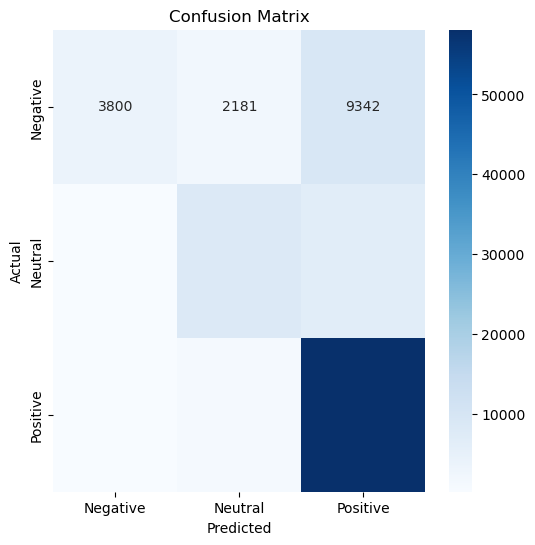

In [55]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

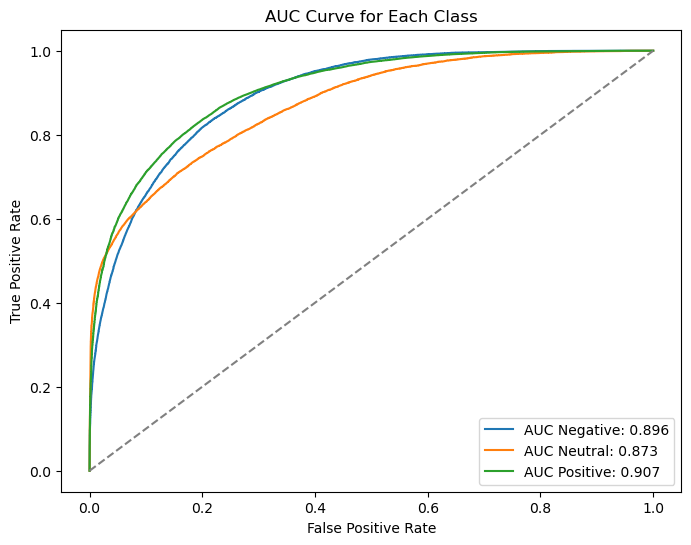

In [57]:
# Convert labels to binary format for AUC
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])

plt.figure(figsize=(8,6))
for i, label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], np.array(y_probs)[:, i])
    plt.plot(fpr, tpr, label=f"AUC {label}: {auc(fpr, tpr):.3f}")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Curve for Each Class")
plt.legend()
plt.show()

In [59]:
results_df

Metric  Accuracy       AUC  F1_Positive  F1_Neutral  F1_Negative  \
0  Training  0.788173       NaN     0.874632    0.644758     0.400610   
1   Testing  0.778269  0.892254     0.868883    0.616196     0.386022   

   Training Time (s)  
0         361.732532  
1                NaN

In [61]:
# Function to compute gradients of the predicted class with respect to input
def get_word_importance(model, tweet_vector):
    model.train()  # Temporarily enable training mode for gradients
    tweet_tensor = torch.tensor(tweet_vector, dtype=torch.float32).unsqueeze(0).to(device)
    tweet_tensor.requires_grad_()

    # Forward pass
    output = model(tweet_tensor)
    predicted_class = torch.argmax(output, dim=1)

    # Compute gradients
    model.zero_grad()  # Clear previous gradients
    output[0, predicted_class].backward(retain_graph=True)
    importance = tweet_tensor.grad.abs().squeeze(0).cpu().numpy()

    model.eval()  # Switch back to evaluation mode
    return importance, predicted_class.item()

# Select a random tweet for interpretation
sample_index = np.random.randint(0, len(df))
sample_tweet = df.iloc[sample_index]["Tweet_Cleaned"]
sample_vector = df.iloc[sample_index]["Tweet_Vector"]
sample_tokens = df.iloc[sample_index]["Tokenized_Tweet"]

# Get word importance scores
importance_scores, predicted_label = get_word_importance(model, sample_vector)

# Print interpretation
print("\n🔍 Interpretation of Sample Tweet:")
print(f"Tweet: {sample_tweet}")
print(f"Predicted Sentiment: {label_encoder.classes_[predicted_label]}")

# Display words with their importance scores
word_importance = list(zip(sample_tokens, importance_scores))
word_importance.sort(key=lambda x: x[1], reverse=True)  # Sort by importance

print("\n🌟 Word Importance Scores:")
for word, score in word_importance[:10]:  # Display top 10 words
    print(f"{word}: {score:.4f}")


🔍 Interpretation of Sample Tweet:
Tweet: Your deductive reasoning skills are appalling &amp; reflect why you canât draw linear conclusions &amp; why the anti-freedom convoy couldnât pull together a coherent message. Using the same s
Predicted Sentiment: Positive

🌟 Word Importance Scores:
message: 2.1265
.: 1.8580
conclusions: 1.5581
deductive: 1.4340
&: 1.2961
couldnât: 1.2842
linear: 1.2534
amp: 1.1647
same: 0.9975
skills: 0.9892


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


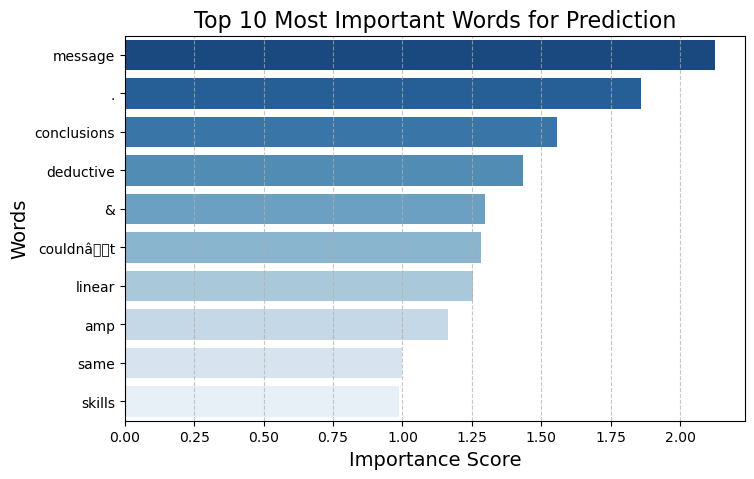

In [63]:
top_words, top_scores = zip(*word_importance[:10])

# Create DataFrame for Seaborn
importance_df = pd.DataFrame({"Word": top_words, "Importance Score": top_scores})

# Plot using Seaborn (Fixed)
plt.figure(figsize=(8, 5))  # Increased figure size
sns.barplot(
    y="Word",
    x="Importance Score",
    data=importance_df,
    palette="Blues_r"
)

plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.title("Top 10 Most Important Words for Prediction", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Add light grid lines
plt.show()

In [65]:
# Function to make predictions for LIME
def lime_predict(texts):
    vectors = [tweet_to_vec(word_tokenize(text.lower()), w2v_model, X_train.shape[1]) for text in texts]
    tensors = torch.tensor(vectors, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(tensors)
    return torch.softmax(outputs, dim=1).cpu().numpy()

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=label_encoder.classes_)

In [67]:
# Explain a random sample tweet
lime_exp = explainer.explain_instance(sample_tweet, lime_predict, num_features=10)

# Show LIME explanation
lime_exp.show_in_notebook()

/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
  tensors = torch.tensor(vectors, dtype=torch.float32).to(device)


In [68]:
# Re-initialize LIME Explainer
explainer = LimeTextExplainer(class_names=label_encoder.classes_)

# Optimized function to run LIME on multiple tweets in parallel
def explain_single_tweet(tweet, top_features):
    try:
        lime_exp = explainer.explain_instance(tweet, lime_predict, num_features=top_features, num_samples=500)
        return lime_exp.as_list()
    except Exception as e:
        return []  # Skip tweets that cause errors

def optimized_global_lime(n_samples=50, top_features=5):
    word_importance = defaultdict(float)

    # Ensure we don't select more samples than available
    n_samples = min(n_samples, len(df))
    
    # Select random tweets
    sample_tweets = df.sample(n=n_samples, random_state=42)["Tweet_Cleaned"].tolist()

    # Run LIME in parallel (multi-threaded for speed)
    explanations = Parallel(n_jobs=-1)(
        delayed(explain_single_tweet)(tweet, top_features) for tweet in sample_tweets
    )

    # Aggregate feature importance
    for exp in explanations:
        for word, score in exp:
            word_importance[word] += abs(score)

    # Sort words by importance
    sorted_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)[:top_features]
    
    return sorted_words

# Run Optimized Global LIME
global_lime_results = optimized_global_lime(n_samples=50, top_features=10)

# Display top influential words globally
print("\n Optimized Global LIME: Most Influential Words Across Multiple Samples")
for word, score in global_lime_results:
    print(f"{word}: {score:.4f}")

/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider convertin


 Optimized Global LIME: Most Influential Words Across Multiple Samples
Freedom: 6.6984
freedom: 1.8128
Convoy: 1.4985
FREEDOM: 0.8530
convoy: 0.8441
die: 0.4913
Emergency: 0.3409
the: 0.2916
of: 0.2749
is: 0.2681


In [70]:
# # Convert results into DataFrame
# lime_global_df = pd.DataFrame(global_lime_results, columns=["Word", "Importance Score"])

# # Plot using Seaborn
# plt.figure(figsize=(8, 5))
# sns.barplot(y="Word", x="Importance Score", data=lime_global_df, hue="Word", palette="Blues_r")
# plt.xlabel("Importance Score")
# plt.ylabel("Words")
# plt.title(" Optimized Global LIME: Most Influential Words for Sentiment Prediction")
# plt.show()

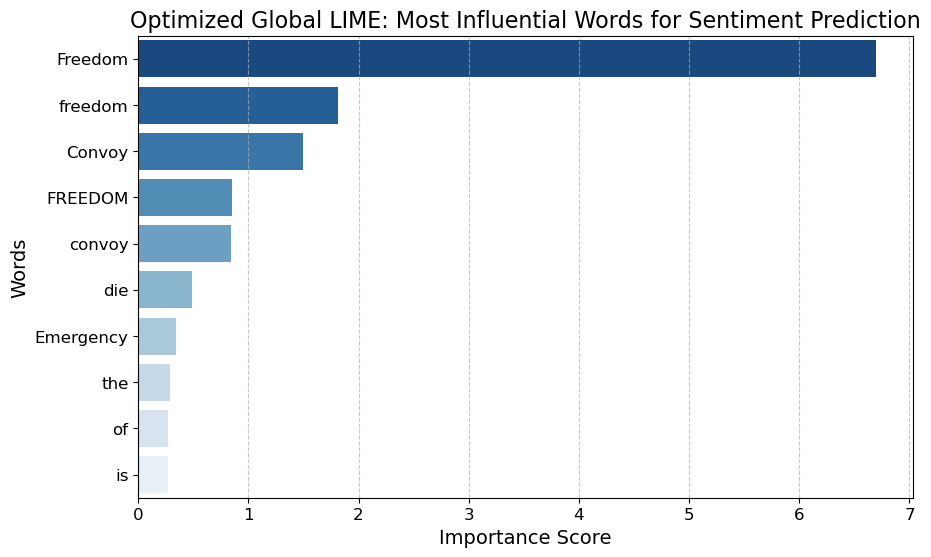

In [71]:
lime_global_df = pd.DataFrame(global_lime_results, columns=["Word", "Importance Score"])

# Plot using Seaborn (Fixed)
plt.figure(figsize=(10, 6))  # Increased figure size
sns.barplot(
    y="Word",
    x="Importance Score",
    data=lime_global_df,
    palette="Blues_r"
)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.title("Optimized Global LIME: Most Influential Words for Sentiment Prediction", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Light grid lines for better readability
plt.show()

## Tuning 

In [76]:
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.4):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Bi-directional output
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension
        gru_out, _ = self.gru(x)
        out = self.dropout(gru_out[:, -1, :])  # Last output from Bi-GRU
        out = self.fc(out)
        return out

# Model Parameters (Tuning 1)
input_size = X_train.shape[1]  # Embedding size (Word2Vec)
hidden_size = 256  # Increased for better feature learning
output_size = len(np.unique(y))  # 3 classes (Positive, Neutral, Negative)
num_layers = 2  # Increased to capture deeper dependencies
dropout = 0.4  # Increased dropout to prevent overfitting

# Initialize Model
model = BiGRU(input_size, hidden_size, output_size, num_layers, dropout)
print(model)

BiGRU(
  (gru): GRU(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


# BiGRU Model Tuning 1

- **Hidden Size**: Increased from **128** to **256** to allow the model to learn more complex sequential patterns.  
- **Number of Layers**: Increased from **1** to **2** for capturing deeper dependencies in the data.  
- **Dropout**: Increased from **0.3** to **0.4** to prevent overfitting and improve generalization.

In [79]:
# # Convert class weights to tensor for PyTorch
# class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float32)

# # Define loss function with class weighting
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# # Define optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # Move model & tensors to GPU (if available)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# criterion.to(device)

# Convert class weights to tensor and move to the correct device
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float32).to(device)

# Define loss function with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define optimizer (adjusted learning rate and weight decay)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Move model and criterion to GPU (if available)
model.to(device)
criterion.to(device)


CrossEntropyLoss()

**Optimizer:** `AdamW` with `lr=0.0005`, `weight_decay=1e-5` for better regularization

In [82]:
num_epochs = 30  # Max epochs
patience = 5  # Early stopping patience
best_val_loss = float("inf")
early_stop_count = 0

results = []

print("Training Started...")
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    y_train_pred, y_train_true = [], []

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(batch_y.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    y_val_pred, y_val_true = [], []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_val_pred.extend(predicted.cpu().numpy())
            y_val_true.extend(batch_y.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    avg_val_loss = total_val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_count = 0
        torch.save(model, "best_biGRU_model.pth")  # Save best model
    else:
        early_stop_count += 1

    if early_stop_count >= patience:
        print("Early stopping triggered!")
        break

training_time = time.time() - start_time
print(f"Training Completed in {training_time:.2f} seconds")

Training Started...
Epoch [1/30] - Train Loss: 0.5182 | Train Acc: 0.7132 | Val Loss: 0.4922 | Val Acc: 0.7289
Epoch [2/30] - Train Loss: 0.4875 | Train Acc: 0.7276 | Val Loss: 0.4795 | Val Acc: 0.7339
Epoch [3/30] - Train Loss: 0.4727 | Train Acc: 0.7349 | Val Loss: 0.4612 | Val Acc: 0.7366
Epoch [4/30] - Train Loss: 0.4622 | Train Acc: 0.7410 | Val Loss: 0.4620 | Val Acc: 0.7549
Epoch [5/30] - Train Loss: 0.4546 | Train Acc: 0.7447 | Val Loss: 0.4537 | Val Acc: 0.7455
Epoch [6/30] - Train Loss: 0.4470 | Train Acc: 0.7486 | Val Loss: 0.4413 | Val Acc: 0.7555
Epoch [7/30] - Train Loss: 0.4406 | Train Acc: 0.7514 | Val Loss: 0.4432 | Val Acc: 0.7474
Epoch [8/30] - Train Loss: 0.4346 | Train Acc: 0.7554 | Val Loss: 0.4299 | Val Acc: 0.7529
Epoch [9/30] - Train Loss: 0.4288 | Train Acc: 0.7579 | Val Loss: 0.4289 | Val Acc: 0.7618
Epoch [10/30] - Train Loss: 0.4232 | Train Acc: 0.7614 | Val Loss: 0.4233 | Val Acc: 0.7637
Epoch [11/30] - Train Loss: 0.4187 | Train Acc: 0.7640 | Val Loss: 0.

In [95]:
model.eval()

y_pred, y_true, y_probs = [], [], []
y_train_pred, y_train_true = [], []

# Evaluate on Test Data
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())
        y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Evaluate on Train Data
with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)

        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(batch_y.cpu().numpy())

# Compute Metrics
train_accuracy = accuracy_score(y_train_true, y_train_pred)
test_accuracy = accuracy_score(y_true, y_pred)

train_report = classification_report(y_train_true, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
test_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

test_auc = roc_auc_score(y_true, y_probs, multi_class="ovr")

# Create a structured DataFrame with two rows: Training & Testing
results_df = pd.DataFrame([
    {
        "Metric": "Training",
        "Accuracy": train_accuracy,
        "AUC": np.nan,  # AUC not computed for training
        "F1_Positive": train_report["Positive"]["f1-score"],
        "F1_Neutral": train_report["Neutral"]["f1-score"],
        "F1_Negative": train_report["Negative"]["f1-score"],
        "Training Time (s)": training_time
    },
    {
        "Metric": "Testing",
        "Accuracy": test_accuracy,
        "AUC": test_auc,
        "F1_Positive": test_report["Positive"]["f1-score"],
        "F1_Neutral": test_report["Neutral"]["f1-score"],
        "F1_Negative": test_report["Negative"]["f1-score"],
        "Training Time (s)": np.nan  # Not applicable for testing
    }
])

# Save results
results_df.to_csv("BiGRU_Results_1.csv", index=False)

print("\nModel Evaluation:")
print("\nResults saved as 'BiGRU_Results_1.csv'.")


Model Evaluation:

Results saved as 'BiGRU_Results_1.csv'.


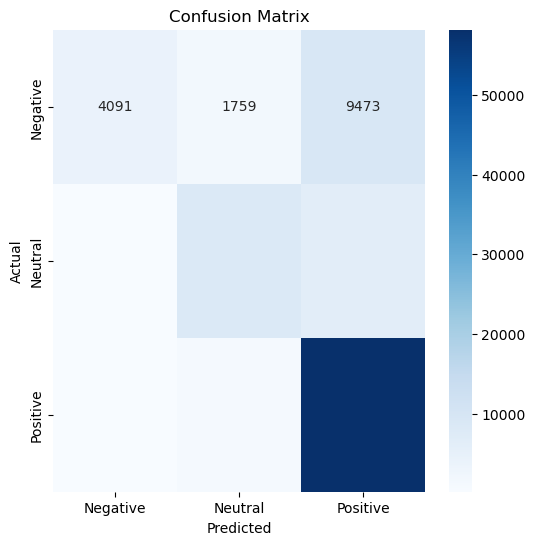

In [96]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

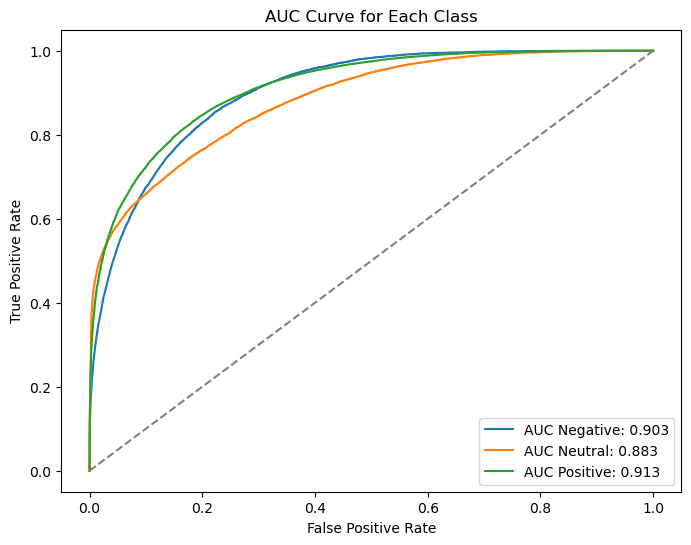

In [99]:
# Convert labels to binary format for AUC
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])

plt.figure(figsize=(8,6))
for i, label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], np.array(y_probs)[:, i])
    plt.plot(fpr, tpr, label=f"AUC {label}: {auc(fpr, tpr):.3f}")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Curve for Each Class")
plt.legend()
plt.show()

In [101]:
print(results_df)

     Metric  Accuracy       AUC  F1_Positive  F1_Neutral  F1_Negative  \
0  Training  0.802686       NaN     0.880074    0.689585     0.440176   
1   Testing  0.784107  0.899276     0.869892    0.635561     0.409489   

   Training Time (s)  
0         824.617427  
1                NaN  


In [103]:
# Select a random tweet for interpretation
sample_index = np.random.randint(0, len(df))
sample_tweet = df.iloc[sample_index]["Tweet_Cleaned"]
sample_vector = df.iloc[sample_index]["Tweet_Vector"]
sample_tokens = df.iloc[sample_index]["Tokenized_Tweet"]

# Get word importance scores
importance_scores, predicted_label = get_word_importance(model, sample_vector)

# Print interpretation
print("\n🔍 Interpretation of Sample Tweet:")
print(f"Tweet: {sample_tweet}")
print(f"Predicted Sentiment: {label_encoder.classes_[predicted_label]}")

# Display words with their importance scores
word_importance = list(zip(sample_tokens, importance_scores))
word_importance.sort(key=lambda x: x[1], reverse=True)  # Sort by importance

print("\n🌟 Word Importance Scores:")
for word, score in word_importance[:10]:  # Display top 10 words
    print(f"{word}: {score:.4f}")


🔍 Interpretation of Sample Tweet:
Tweet: "When is white history month?" ð¤ "Straight pride parade!" Freedom Convoy
Predicted Sentiment: Positive

🌟 Word Importance Scores:
!: 3.1586
history: 2.4447
freedom: 2.0506
white: 1.8552
``: 1.8323
month: 1.7868
parade: 1.7812
is: 1.7425
when: 1.6646
'': 1.5739


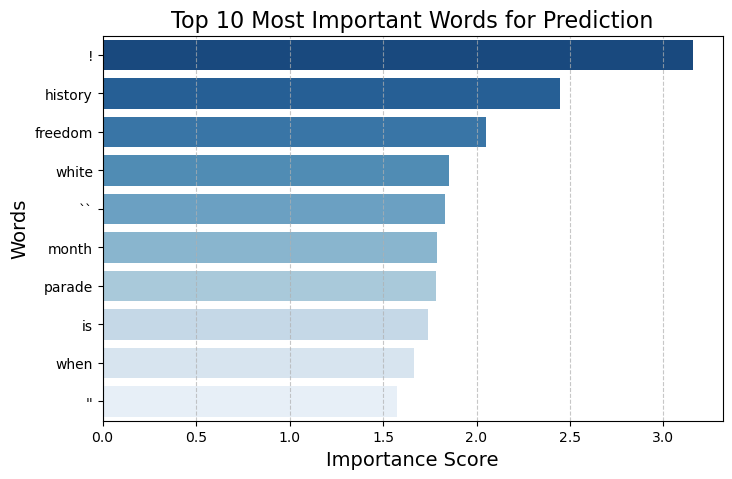

In [105]:
top_words, top_scores = zip(*word_importance[:10])

# Create DataFrame for Seaborn
importance_df = pd.DataFrame({"Word": top_words, "Importance Score": top_scores})

# Plot using Seaborn (Fixed)
plt.figure(figsize=(8, 5))  # Increased figure size
sns.barplot(
    y="Word",
    x="Importance Score",
    data=importance_df,
    palette="Blues_r"
)

plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.title("Top 10 Most Important Words for Prediction", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Add light grid lines
plt.show()

In [107]:
explainer = LimeTextExplainer(class_names=label_encoder.classes_)

In [109]:
lime_exp = explainer.explain_instance(sample_tweet, lime_predict, num_features=10)

# Show LIME explanation
lime_exp.show_in_notebook()

In [111]:
global_lime_results = optimized_global_lime(n_samples=50, top_features=10)

# Display top influential words globally
print("\n Optimized Global LIME: Most Influential Words Across Multiple Samples")
for word, score in global_lime_results:
    print(f"{word}: {score:.4f}")

/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider convertin


 Optimized Global LIME: Most Influential Words Across Multiple Samples
Freedom: 8.0868
freedom: 1.7061
Convoy: 1.2144
FREEDOM: 0.8983
peaceful: 0.5965
convoy: 0.5664
Emergency: 0.4212
die: 0.3808
and: 0.3250
of: 0.3241


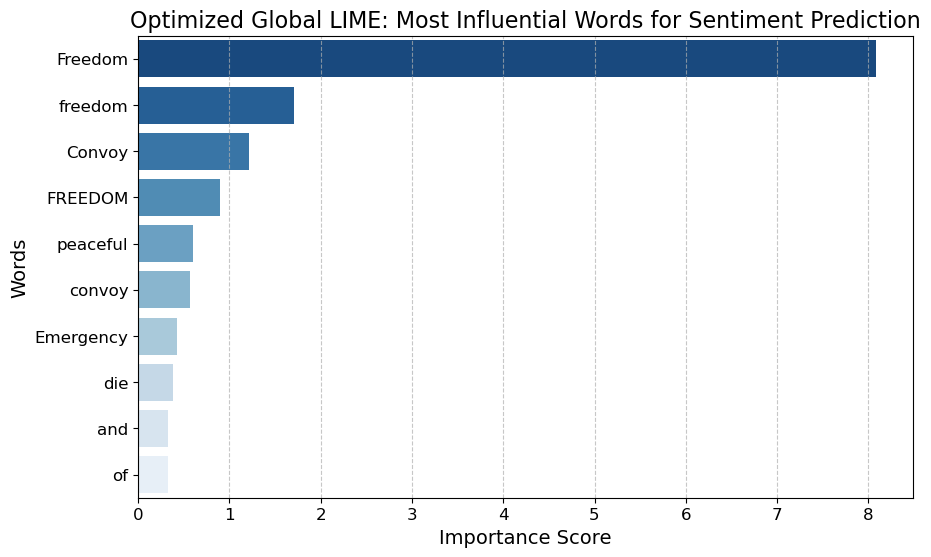

In [112]:
lime_global_df = pd.DataFrame(global_lime_results, columns=["Word", "Importance Score"])

# Plot using Seaborn (Fixed)
plt.figure(figsize=(10, 6))  # Increased figure size
sns.barplot(
    y="Word",
    x="Importance Score",
    data=lime_global_df,
    palette="Blues_r"
)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.title("Optimized Global LIME: Most Influential Words for Sentiment Prediction", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Light grid lines for better readability
plt.show()

## Tuning 2

In [124]:
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.5):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers=num_layers, 
            batch_first=True, bidirectional=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)  # Normalize Bi-GRU output
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension
        gru_out, _ = self.gru(x)
        out = self.layer_norm(gru_out[:, -1, :])  # Apply LayerNorm to last GRU output
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Model Parameters (Tuning 2)
input_size = X_train.shape[1]  # Embedding size (Word2Vec)
hidden_size = 256  # Keeping it the same as tuning 1
output_size = len(np.unique(y))  # 3 classes (Positive, Neutral, Negative)
num_layers = 3
dropout = 0.5  # Increased to improve regularization

# Initialize Model
model = BiGRU(input_size, hidden_size, output_size, num_layers, dropout)
print(model)

BiGRU(
  (gru): GRU(100, 256, num_layers=3, batch_first=True, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# BiGRU Model Tuning 2

- **Number of Layers**: Increased from **2** to **3** for capturing deeper dependencies in the data.  
- **Dropout**: Increased from **0.4** to **0.5** to prevent overfitting and improve generalization.
1. **Optimizer:** 
   - Switched to `AdamW` with a reduced learning rate of `0.0003` and smaller weight decay `1e-6` for better regularization.


In [127]:
# Convert class weights to tensor and move to the correct device
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float32).to(device)

# Define loss function with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define optimizer (AdamW with adjusted learning rate and weight decay)
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-6)  # New learning rate and weight decay

# Gradient Clipping
max_grad_norm = 1.0  # Clip gradients to prevent explosion

# Learning rate scheduler - Reduce learning rate on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)

# Move model and criterion to GPU (if available)
model.to(device)
criterion.to(device)

/opt/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


CrossEntropyLoss()

In [129]:
num_epochs = 20  # Max epochs
patience = 5  # Early stopping patience
best_val_loss = float("inf")
early_stop_count = 0

results = []

# Initialize the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)

print("Training Started...")
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    y_train_pred, y_train_true = [], []

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(batch_y.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    y_val_pred, y_val_true = [], []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_val_pred.extend(predicted.cpu().numpy())
            y_val_true.extend(batch_y.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    avg_val_loss = total_val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_count = 0
        torch.save(model, "best_biGRU_model_tuning2.pth")  # Save best model for tuning 2
    else:
        early_stop_count += 1

    if early_stop_count >= patience:
        print("Early stopping triggered!")
        break

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

training_time = time.time() - start_time
print(f"Training Completed in {training_time:.2f} seconds")

/opt/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Started...
Epoch [1/20] - Train Loss: 0.5238 | Train Acc: 0.7111 | Val Loss: 0.4968 | Val Acc: 0.7258
Epoch [2/20] - Train Loss: 0.4920 | Train Acc: 0.7264 | Val Loss: 0.4827 | Val Acc: 0.7361
Epoch [3/20] - Train Loss: 0.4766 | Train Acc: 0.7341 | Val Loss: 0.4721 | Val Acc: 0.7393
Epoch [4/20] - Train Loss: 0.4665 | Train Acc: 0.7395 | Val Loss: 0.4571 | Val Acc: 0.7420
Epoch [5/20] - Train Loss: 0.4580 | Train Acc: 0.7437 | Val Loss: 0.4551 | Val Acc: 0.7427
Epoch [6/20] - Train Loss: 0.4500 | Train Acc: 0.7476 | Val Loss: 0.4415 | Val Acc: 0.7492
Epoch [7/20] - Train Loss: 0.4430 | Train Acc: 0.7507 | Val Loss: 0.4372 | Val Acc: 0.7553
Epoch [8/20] - Train Loss: 0.4357 | Train Acc: 0.7548 | Val Loss: 0.4380 | Val Acc: 0.7604
Epoch [9/20] - Train Loss: 0.4295 | Train Acc: 0.7577 | Val Loss: 0.4269 | Val Acc: 0.7594
Epoch [10/20] - Train Loss: 0.4234 | Train Acc: 0.7613 | Val Loss: 0.4233 | Val Acc: 0.7550
Epoch [11/20] - Train Loss: 0.4180 | Train Acc: 0.7639 | Val Loss: 0.

In [132]:
model.eval()

y_pred, y_true, y_probs = [], [], []
y_train_pred, y_train_true = [], []

# Evaluate on Test Data
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())
        y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Evaluate on Train Data
with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)

        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(batch_y.cpu().numpy())

# Compute Metrics
train_accuracy = accuracy_score(y_train_true, y_train_pred)
test_accuracy = accuracy_score(y_true, y_pred)

train_report = classification_report(y_train_true, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
test_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

test_auc = roc_auc_score(y_true, y_probs, multi_class="ovr")

# Create a structured DataFrame with two rows: Training & Testing
results_df = pd.DataFrame([
    {
        "Metric": "Training",
        "Accuracy": train_accuracy,
        "AUC": np.nan,  # AUC not computed for training
        "F1_Positive": train_report["Positive"]["f1-score"],
        "F1_Neutral": train_report["Neutral"]["f1-score"],
        "F1_Negative": train_report["Negative"]["f1-score"],
        "Training Time (s)": training_time
    },
    {
        "Metric": "Testing",
        "Accuracy": test_accuracy,
        "AUC": test_auc,
        "F1_Positive": test_report["Positive"]["f1-score"],
        "F1_Neutral": test_report["Neutral"]["f1-score"],
        "F1_Negative": test_report["Negative"]["f1-score"],
        "Training Time (s)": np.nan  # Not applicable for testing
    }
])

# Save results
results_df.to_csv("BiGRU_Results_2.csv", index=False)

print("\nModel Evaluation:")
print("\nResults saved as 'BiGRU_Results_2.csv'.")


Model Evaluation:

Results saved as 'BiGRU_Results_2.csv'.


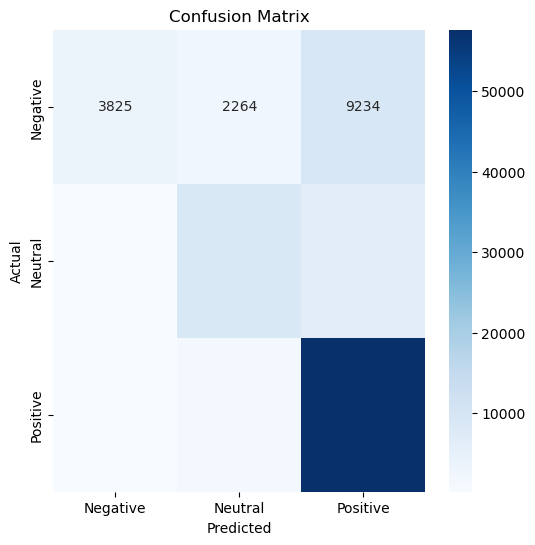

In [134]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

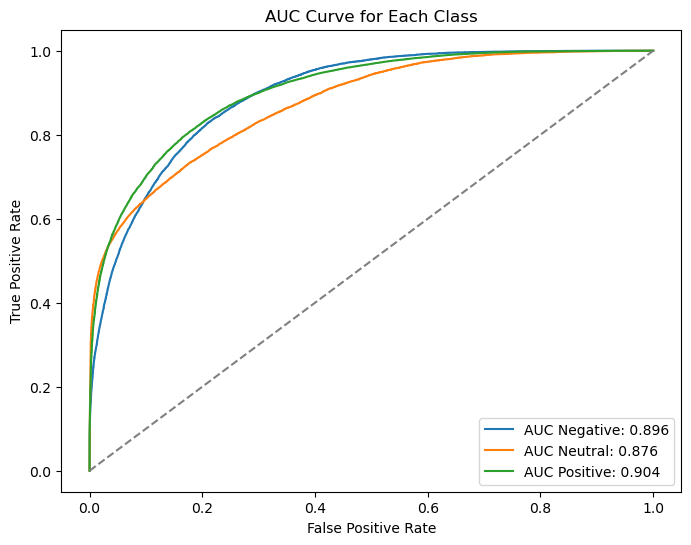

In [136]:
# Convert labels to binary format for AUC
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])

plt.figure(figsize=(8,6))
for i, label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], np.array(y_probs)[:, i])
    plt.plot(fpr, tpr, label=f"AUC {label}: {auc(fpr, tpr):.3f}")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Curve for Each Class")
plt.legend()
plt.show()

In [138]:
print(results_df)

     Metric  Accuracy       AUC  F1_Positive  F1_Neutral  F1_Negative  \
0  Training  0.792051       NaN     0.877165    0.662073     0.404765   
1   Testing  0.778191  0.892153     0.868308    0.624533     0.389075   

   Training Time (s)  
0        1253.416403  
1                NaN  


In [140]:
# Select a random tweet for interpretation
sample_index = np.random.randint(0, len(df))
sample_tweet = df.iloc[sample_index]["Tweet_Cleaned"]
sample_vector = df.iloc[sample_index]["Tweet_Vector"]
sample_tokens = df.iloc[sample_index]["Tokenized_Tweet"]

# Get word importance scores
importance_scores, predicted_label = get_word_importance(model, sample_vector)

# Print interpretation
print("\n🔍 Interpretation of Sample Tweet:")
print(f"Tweet: {sample_tweet}")
print(f"Predicted Sentiment: {label_encoder.classes_[predicted_label]}")

# Display words with their importance scores
word_importance = list(zip(sample_tokens, importance_scores))
word_importance.sort(key=lambda x: x[1], reverse=True)  # Sort by importance

print("\n🌟 Word Importance Scores:")
for word, score in word_importance[:10]:  # Display top 10 words
    print(f"{word}: {score:.4f}")


🔍 Interpretation of Sample Tweet:
Tweet: Remember Freedom Convoy Tribute - Stand On Guard/O Canada by Summit Sounds via
Predicted Sentiment: Positive

🌟 Word Importance Scores:
on: 13.3321
guard/o: 9.2490
tribute: 9.2219
remember: 7.3821
summit: 7.0315
by: 6.8965
-: 5.4718
convoy: 5.1747
freedom: 3.3888
via: 1.9878


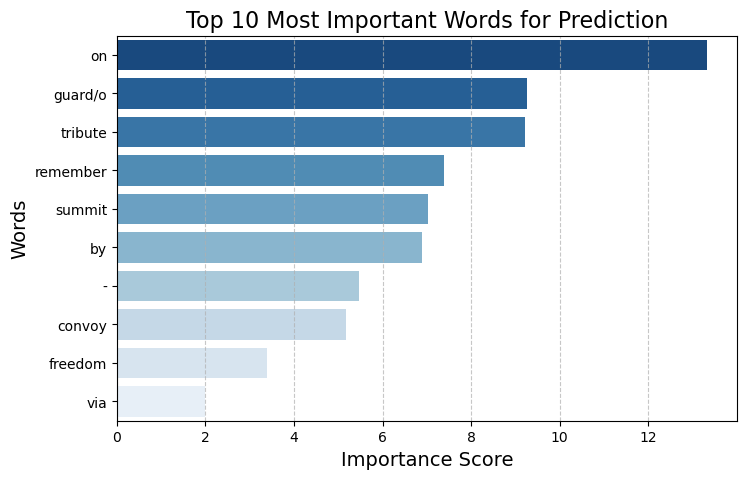

In [142]:
top_words, top_scores = zip(*word_importance[:10])

# Create DataFrame for Seaborn
importance_df = pd.DataFrame({"Word": top_words, "Importance Score": top_scores})

# Plot using Seaborn (Fixed)
plt.figure(figsize=(8, 5))  # Increased figure size
sns.barplot(
    y="Word",
    x="Importance Score",
    data=importance_df,
    palette="Blues_r"
)

plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.title("Top 10 Most Important Words for Prediction", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Add light grid lines
plt.show()

In [144]:
explainer = LimeTextExplainer(class_names=label_encoder.classes_)

In [146]:
lime_exp = explainer.explain_instance(sample_tweet, lime_predict, num_features=10)

# Show LIME explanation
lime_exp.show_in_notebook()

In [148]:
global_lime_results = optimized_global_lime(n_samples=50, top_features=10)

# Display top influential words globally
print("\n Optimized Global LIME: Most Influential Words Across Multiple Samples")
for word, score in global_lime_results:
    print(f"{word}: {score:.4f}")

/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
/var/folders/tz/_kr6c8m90dl2p9klr693qf6w0000gn/T/ipykernel_2381/1603625288.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider convertin


 Optimized Global LIME: Most Influential Words Across Multiple Samples
Freedom: 8.5207
freedom: 1.9104
Convoy: 1.0791
FREEDOM: 1.0384
convoy: 0.5373
die: 0.5160
Emergency: 0.3712
the: 0.3625
sedition: 0.3357
protestors: 0.2843


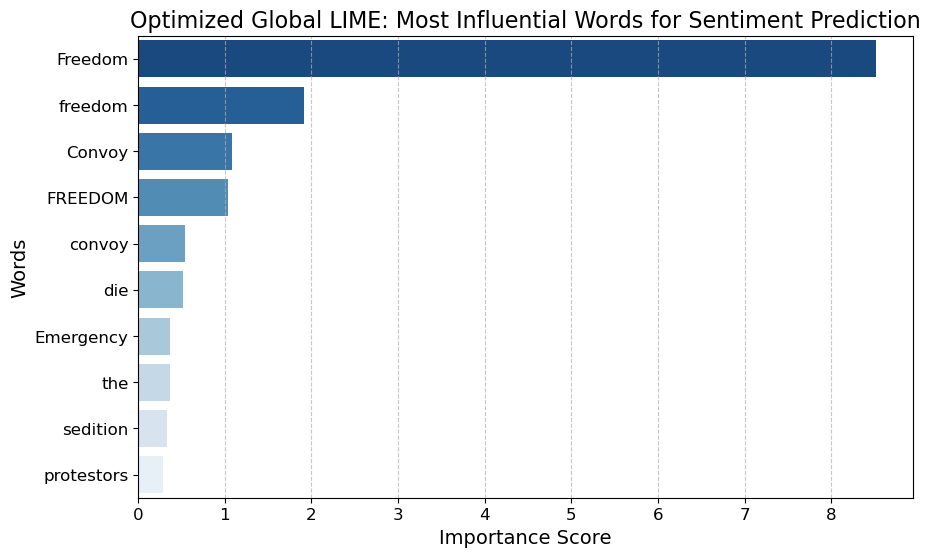

In [149]:
lime_global_df = pd.DataFrame(global_lime_results, columns=["Word", "Importance Score"])

# Plot using Seaborn (Fixed)
plt.figure(figsize=(10, 6))  # Increased figure size
sns.barplot(
    y="Word",
    x="Importance Score",
    data=lime_global_df,
    palette="Blues_r"
)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.title("Optimized Global LIME: Most Influential Words for Sentiment Prediction", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Light grid lines for better readability
plt.show()